# Sample DCGAN Implementation using Keras

To illustrate the implementation of a GAN using Python, we use the [Deep Convolutional GAN](https://arxiv.org/abs/1511.06434 (DCGAN) example discussed in the Section 'Evolution of GAN Architectures' to synthesize images from the fashion MNIST dataset. 

Adapted from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
%matplotlib inline
import sys
from time import time
import numpy as np
import IPython
from IPython import display
import imageio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, Activation,
                                     ZeroPadding2D, LeakyReLU, UpSampling2D,
                                     Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'imageio'

## Helper

In [5]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [6]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.tight_layout()
    fig.savefig('images/gan/fashion_mnist_{}.png'.format(epoch))

In [7]:
cross_entropy = BinaryCrossentropy(from_logits=True)

## Build Discriminator

Both the discriminator and generator use a deep CNN architecture, wrapped in a function:

In [8]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), 
               strides=(2, 2), 
               padding='same',
               input_shape=[28, 28, 1],
              name='CONV1'),
        LeakyReLU(name='RELU1'),
        Dropout(0.3, name='DO1'),
        
        Conv2D(128, (5, 5), 
               strides=(2, 2), 
               padding='same',
              name='CONV2'),
        LeakyReLU(name='RELU2'),
        Dropout(0.3, name='DO2'),
        
        Flatten(name='FLAT'),
        Dense(1, name='OUT')
    ], name='Discriminator')

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [9]:
discriminator = build_discriminator()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 14, 14, 64)        1664      
_________________________________________________________________
RELU1 (LeakyReLU)            (None, 14, 14, 64)        0         
_________________________________________________________________
DO1 (Dropout)                (None, 14, 14, 64)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 7, 7, 128)         204928    
_________________________________________________________________
RELU2 (LeakyReLU)            (None, 7, 7, 128)         0         
_________________________________________________________________
DO2 (Dropout)                (None, 7, 7, 128)         0         
_________________________________________________________________
FLAT (Flatten)               (None, 6272)            

A call to this function and subsequent compilation shows that this network has over 393,000 parameters.

In [10]:
def discriminator_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

In [11]:
# Build and compile the discriminator
discriminator = build_discriminator()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 14, 14, 64)        1664      
_________________________________________________________________
RELU1 (LeakyReLU)            (None, 14, 14, 64)        0         
_________________________________________________________________
DO1 (Dropout)                (None, 14, 14, 64)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 7, 7, 128)         204928    
_________________________________________________________________
RELU2 (LeakyReLU)            (None, 7, 7, 128)         0         
_________________________________________________________________
DO2 (Dropout)                (None, 7, 7, 128)         0         
_________________________________________________________________
FLAT (Flatten)               (None, 6272)            

## Build Generator

The generator network is slightly shallower but has more than twice as many parameters:

In [12]:
def build_generator():
    model = Sequential([
        Dense(7 * 7 * 256, 
              use_bias=False, 
              input_shape=(100, ),
             name='IN'),
        BatchNormalization(name='BN1'),
        LeakyReLU(name='RELU1'),
        
        Reshape((7, 7, 256), name='SHAPE1'),
        Conv2DTranspose(128, (5, 5),
                        strides=(1, 1),
                        padding='same',
                        use_bias=False,
                       name='CONV1'),
        BatchNormalization(name='BN2'),
        LeakyReLU(name='RELU2'),
        
        Conv2DTranspose(64, (5, 5),
                        strides=(2, 2),
                        padding='same',
                        use_bias=False,
                       name='CONV2'),
        BatchNormalization(name='BN3'),
        LeakyReLU(name='RELU3'),
        
        Conv2DTranspose(1, (5, 5),
                        strides=(2, 2),
                        padding='same',
                        use_bias=False,
                        activation='tanh',
                       name='CONV3')
    ], name='Generator')

    model.summary()
    noise = Input(shape=(latent_dim, ))
    img = model(noise)

    return Model(noise, img)

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator = build_generator()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN (Dense)                   (None, 12544)             1254400   
_________________________________________________________________
BN1 (BatchNormalization)     (None, 12544)             50176     
_________________________________________________________________
RELU1 (LeakyReLU)            (None, 12544)             0         
_________________________________________________________________
SHAPE1 (Reshape)             (None, 7, 7, 256)         0         
_________________________________________________________________
CONV1 (Conv2DTranspose)      (None, 7, 7, 128)         819200    
_________________________________________________________________
BN2 (BatchNormalization)     (None, 7, 7, 128)         512       
_________________________________________________________________
RELU2 (LeakyReLU)            (None, 7, 7, 128)         0 

## Load the Data

In [15]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [16]:
train_images = np.vstack((x_train, x_test)) 
train_images = train_images.reshape(train_images.shape[0], 
                                    28, 
                                    28, 
                                    1).astype('float32')

In [17]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [18]:
train_labels = np.hstack((y_train, y_test))

In [19]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [20]:
train_dataset = (tf.data.Dataset
                 .from_tensor_slices(train_images)
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE))

## Adversarial Training

Adversarial training iterates over the epochs, generates random image and noise input, and trains both the discriminator and the generator (as part of the combined model):

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    generator_gradients = gen_tape.gradient(gen_loss, 
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time()

    for image_batch in dataset:
        train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)


    print (f'Time for epoch {epoch + 1} is {time()-start:.2f} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

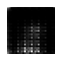

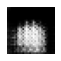

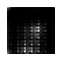

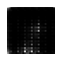

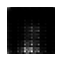

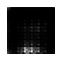

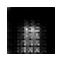

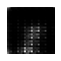

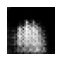

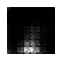

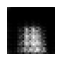

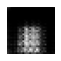

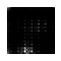

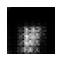

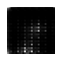

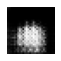

In [25]:
train(train_dataset, EPOCHS)

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)


if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

NameError: name 'imageio' is not defined

After 10,000 epochs, which only take a few minutes, the synthetic images created from random noise clearly resemble the originals:

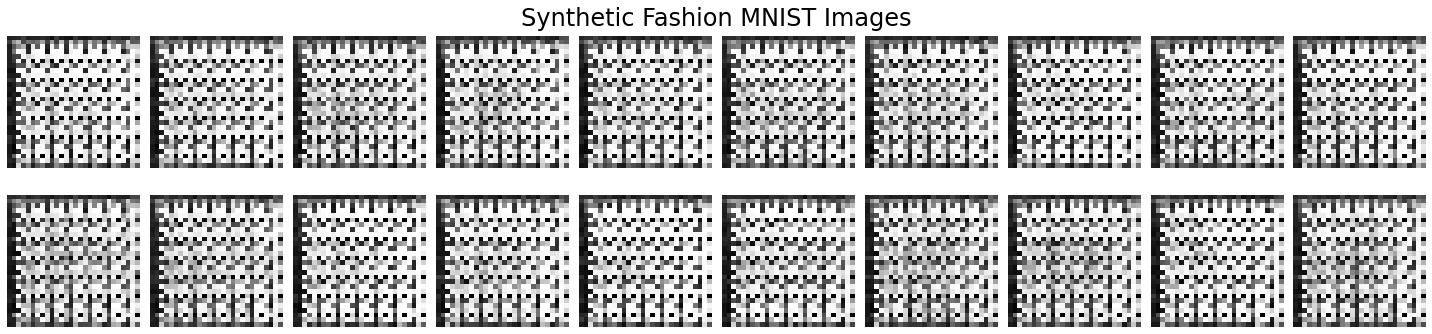

In [17]:
r, c = 2, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(20, 5))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

fig.suptitle('Synthetic Fashion MNIST Images', fontsize=24),
fig.tight_layout()
fig.subplots_adjust(top=.96)
fig.savefig('images/fashion_mnist.png', dpi=300)